<a href="https://colab.research.google.com/github/YifanXu1999/VAE/blob/master/AutoEnocderMNIST_10000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
!pip install tsne
from tsne import bh_sne

  Created wheel for tsne: filename=tsne-0.1.8-cp36-cp36m-linux_x86_64.whl size=226361 sha256=6ad2496d3d85303739d32ed4c8919e7a58a68dfbc2474914d252d22236374df0
  Stored in directory: /root/.cache/pip/wheels/69/b4/26/9a673d2333de6af3865b5a2b462b3b0cfe4556ae69979434dd
Successfully built tsne


In [2]:
trainData = DataLoader(MNIST(root='./root', train=True, download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=128)
testData = DataLoader(MNIST(root='./root', train=False, download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=5000)

Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw


Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw
Processing...
Done!


In [0]:
class AutoEnocder(nn.Module):
  def __init__(self, hidden_dim=500, latent_dim=10000, norm_factor=1):
    super(AutoEnocder, self).__init__()
    self.encode_z = nn.Sequential(
        nn.Linear(784, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, latent_dim)
    )
    self.decode_output = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 784),
        nn.Sigmoid()
    )
    self.norm_factor = norm_factor
  
  def encode(self, x_in):
    return (self.encode_z(x_in.view(-1, 784)) * self.norm_factor)
  
  def decode(self, z):
    return self.decode_output(z).view(-1, 1, 28, 28)
  
  def forward(self, x_in):
    z = torch.relu(self.encode(x_in))
    return self.decode(z)


In [0]:
model = AutoEnocder(norm_factor=1)
optimizer = torch.optim.Adam(model.parameters())

In [0]:
def train(model, optimizer, dataset, epochs=4):
  losses = []
  for epoch in range(epochs):
    for images, label in dataset:
      x_in = images
      x_out = model(x_in)
      optimizer.zero_grad()
      loss = 0.5 * (x_out - x_in).pow(2).sum() / x_in.size(0)
      losses.append(loss)
      loss.backward()
      optimizer.step()
  return losses

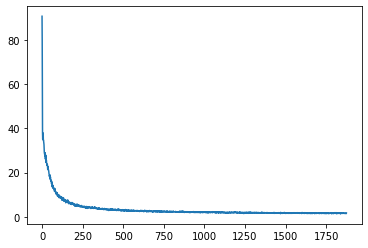

In [6]:
losses = train(model, optimizer, trainData)
plt.plot(losses)
plt.show()

In [0]:
def imshow(img):
    npimg = img.numpy()
    
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.axis('off')
    plt.show()


def add_noise(x, noise_factor=0.3):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x
def visualize(images, label, model):
  x_in = images
  x_out = model(x_in.view(-1, 28 * 28)).data
  z = model.encode(x_in)
  imshow(make_grid(x_in[0:16]))
  imshow(make_grid(x_out[0:16]))
  return z.data.numpy()
#z = np.float64(z)
#z = bh_sne(z)
#plt.figure(figsize=(10, 10))
#plt.scatter(z[:, 0], z[:, 1], c=label, cmap='brg')
#plt.colorbar()

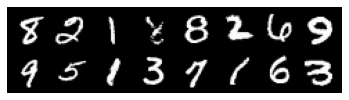

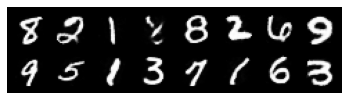

In [8]:
imgs, label = iter(testData).next()
z = visualize(imgs, label, model)

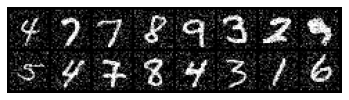

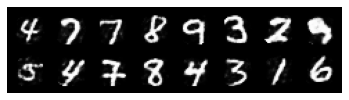

In [10]:
imgs, label = iter(testData).next()
imgs = torch.FloatTensor(add_noise(imgs.data.numpy(), 0.2))
z = visualize(imgs, label, model)

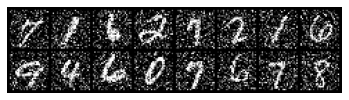

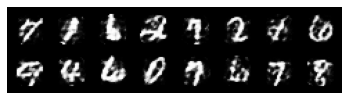

In [15]:
imgs, label = iter(testData).next()
imgs = torch.FloatTensor(add_noise(imgs.data.numpy(), 0.4))
z = visualize(imgs, label, model)